In [70]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import gamma, loggamma

sns.set_style("whitegrid")

%matplotlib inline

## Задача 6. Белые мышки.

Скачайте <a href="https://www.kaggle.com/ruslankl/mice-protein-expression
">датасет</a> с данными об экспрессии белков у белых мышей. Данный датасет состоит из таблицы значений уровней экспрессии 77 различных белков в мозге у мышей. Каждая строка соответствует одной особи, каждый столбец соответствует одному белку. На столбцы Genotype, Treatment и подобные пока не обращаем внимания. 

In [71]:
df = pd.read_csv("./Data_Cortex_Nuclear.csv") 

Выберем для анализа белки ITSN1_N, DYRK1A_N, pBRAF_N, pCREB_N.

In [72]:
columns = ['ITSN1_N', 'DYRK1A_N', 'pBRAF_N', 'pCREB_N']  

df_chosen_columns = df[columns]

Постройте гистограммы изучаемых признаков.

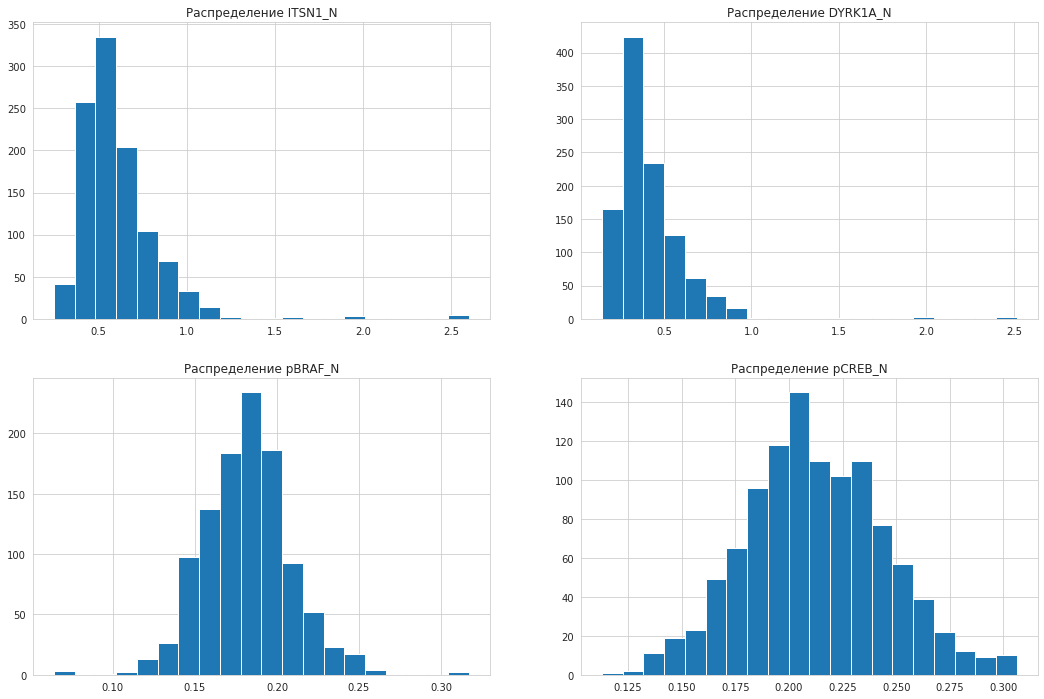

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for i, col in enumerate(columns):
    axs[i//2, i%2].hist(df_chosen_columns[col], bins=20)
    axs[i//2, i%2].set_title('Распределение ' + col)

plt.show()

**1.** 

В этой части задания вам предлагается найти оценки максимального правдоподобия (ОМП) по формулам, полученным в теоретической части задания. Если вам не удалось посчитать теоретически какую-то из нужных ОМП, сделайте хотя бы для той, которую посчитали.

Предположим, что признаки имеют следующие распределения: 


*   'pBRAF_N' и 'pCREB_N' &mdash; нормальное распределение с неизвестными параметрами $\theta = (a, \sigma^2)$;
*  'ITSN1_N' &mdash; гамма-распределение $Gamma(\theta, \beta)$ с плотностью $p_{\theta}(x) = \frac{\theta^{\beta} x^{\beta-1}}{\Gamma(\beta)} e^{-\theta x} $ с неизвестным параметром $\theta$ и известным параметром $\beta$, равным 13.5;
* 'DYRK1A_N' &mdash; гамма-распределение $Gamma(\theta, \beta)$ с неизвестным параметром $\theta$ и известным параметром $\beta$, равным 9.

Не пугайтесь гамма-распределения, оно тоже часто встречается, как мы и увидим в этой задаче.

*Замечание:* в `scipy.stats` у гамма-распределения параметр `a` означает $\beta$, а параметр `scale` означает $1 / \theta$.


Удалите неопределенные значения `nan` и выбросы и посчитайте ОМП для данных выборок признаков, предполагая, что они имеют указанные выше распределения. Подсчет ОМП оформите в виде функций, принимающих реализацию выборки и $\beta$ в случае гамма-распределения. Выведите полученные значения параметров.

Для избавления от копипаста используйте циклы и функции. Копипаст является серезным источником ошибок на практике.

In [74]:
def MLE_gamma(sample, beta):
    '''Возвращает ОМП theta при известном beta'''

    # MLE = maximum likelihood estimation

    return beta / sample.mean()

def MLE_norm(sample):
    '''Возвращает ОМП (a, sigma)'''

    # считаем sigma, а не sigma^2, т.к. есть биекция, 
    # а считать sigma удобнее для практики
    return sample.mean(), sample.std()

Удаление выбросов и nan:

In [75]:
clear = dict()  # словарь с выборками, т.к. после удаления выбросов получатся выборки разного размера

for col in columns:
    sample = df[col]
    sample = sample.dropna()  # удаление nan
    if col in ['DYRK1A_N','ITSN1_N']:
      sample = sample[sample < 1.2]  # удаление выбросов

    clear[col] = sample

Подсчет ОМП:

In [76]:
params = dict()  #словарь с параметрами

for col, beta in [('DYRK1A_N', 9), ('ITSN1_N', 13.5)]:
    sample = clear[col]

    # параметры для гамма-распределения с учетом известной beta
    params[col] = (MLE_gamma(sample, beta), beta)  
    print("Параметры для ", col, ": ", "theta = ", round(params[col][0], 3), 
          ", beta = ", params[col][1], sep='')

for col in ['pBRAF_N', 'pCREB_N']:
    sample = clear[col]
    
    # параметры для нормального распределения
    params[col] = MLE_norm(sample)  
    print("Параметры для ", col, ": ", "a = ", round(params[col][0], 3), 
          ", sigma = ", round(params[col][1], 3), sep='')


Параметры для DYRK1A_N: theta = 22.329, beta = 9
Параметры для ITSN1_N: theta = 22.72, beta = 13.5
Параметры для pBRAF_N: a = 0.182, sigma = 0.027
Параметры для pCREB_N: a = 0.213, sigma = 0.033


Постройте для каждого признака на одном графике гистограмму каждого признака, график ядерной оценки плотности и график плотности распределения с параметрами, являющимися полученной ОМП. Графики для разных признаков стройте на разных графиков, но в одном окне. Сравните получившиеся результаты. Сделайте выводы.

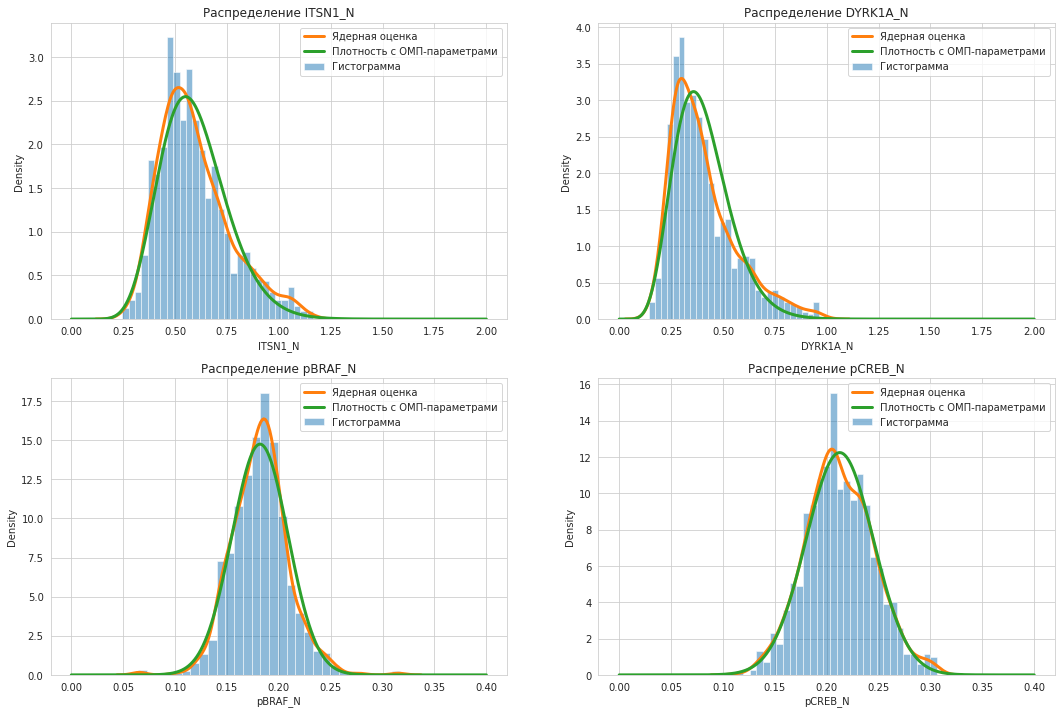

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for i, col in enumerate(columns):
    axs[i//2, i%2].set_title("Распределение " + col)

    sample = clear[col]
    axs[i//2, i%2].hist(sample, alpha=0.5, bins=30, 
                        density=True, label="Гистограмма")
    sns.kdeplot(sample, ax=axs[i//2, i%2], linewidth=3, label="Ядерная оценка")
    
    if col in ['pBRAF_N', 'pCREB_N']:
       grid = np.linspace(0, 0.4, 1000)
       axs[i//2, i%2].plot(grid, sps.norm(loc=params[col][0], scale=params[col][1]).pdf(grid), 
                           linewidth=3, label = "Плотность с ОМП-параметрами")
    else:
        grid = np.linspace(0, 2, 1000)
        axs[i//2, i%2].plot(grid, sps.gamma(scale=1/params[col][0], a=params[col][1]).pdf(grid), 
                            linewidth=3, label = "Плотность с ОМП-параметрами")

    axs[i//2, i%2].legend()
plt.show()



**Вывод**

По графику видно, что плотность распределения с параметрами, являющимися оценками максимального правдоподобия, похожа на ядерную оценку плотности и неплохо соотносится с гистограммой. Таким образом, метод максимального правдоподобия дает оценку, хорошо приближающую действительность. Также можно заметить, что в случае гамма-распределения, возможно, стоит также перебрать параметр beta, т.к. график плотности немного сдвинут относительно графика ядерной оценки.

**2.**


Реализуйте функции, возвращающие значения функции правдоподобия  и логарифмической функции правдоподобия для гамма распределения с параметрам $\theta, \beta$. Функция принимает реализацию выборки и параметры. Логарифмическую функцию реализуйте с использованием формулы после ее упрощения, а не как взятие функции логарифма от уже вычисленного значения функции правдоподобия.

Для получения частичного балла можно использовать методы `pdf` и `logpdf` для плотности и логарифма плотности распределения в `scipy.stats`, для получения полного балла функции формулу нужно реализовать самостоятельно.

Для подсчета гамма-функции (в знаменателе плотности распределения) используйте `scipy.special.gamma`, а для подсчета логарифма гамма-функции &mdash; `scipy.special.loggamma`. 



*Формулы для вычисления:*

$L_x(\theta) = \prod\limits_{i=1}^n\frac{\theta^{\beta}X_i^{\beta-1}}{\Gamma(\beta)}e^{-\theta X_i}$

$l_X(\theta) = \sum\limits_{i=1}^n \left[\beta \log \theta +(\beta-1)\log X_i - \log {\Gamma(\beta)} {-\theta X_i}\right] = n \beta \log \theta - n \log \Gamma(\beta) + (\beta-1) \sum\limits_{i=1}^n \log X_i - \theta\sum\limits_{i=1}^n X_i$



In [78]:
def likelihood(sample, theta, beta):
    '''Возвращает значение функции правдоподобия 
    для реализации выборки sample и параметров theta, beta'''
    
    # частичный балл
    # return sps.gamma(a=beta, scale=1/theta).pdf(sample).prod())  

    return np.prod(((theta**beta) * (sample**(beta - 1)) * 
                    np.exp(-theta * sample)) / gamma(beta))

def log_likelihood(sample, theta, beta):
    '''Возвращает значение логарифмической функции правдоподобия 
    для реализации выборки sample и параметров theta, beta'''

    n = len(sample)
    
    # частичный балл
    # return sps.gamma(a=beta, scale=1/theta).logpdf(sample).sum()  

    return n * (beta * np.log(theta) - loggamma(beta) + 
                (beta - 1) * np.mean(np.log(sample)) - theta * np.mean(sample))

Выведите следующие значения:
- функции правдоподобия;
- логарифма, взятого от функции правдоподобия;
- логарифмической функции правдоподобия

на следующих реализациях выборок:
- `np.ones(5)*5` &mdash; 5 пятерок;
- `np.ones(500)*5`&mdash; 500 пятерок;

Параметр $\beta$ положите равным 10, параметр $\theta$ положите равным 2.

Сделайте выводы. Какую функцию лучше вычислять на практике?


In [79]:
sample = np.ones(5)*5
print("Выборка np.ones(5)*5")
print("Значение ФП:", "%.5f" %  likelihood(sample, 2, 10))
print("Значение логарифма ФП:", "%.5f" %  np.log(likelihood(sample, 2, 10)).sum())
print("Значение логарифмической ФП:",  "%.5f" %  log_likelihood(sample, 2, 10))

Выборка np.ones(5)*5
Значение ФП: 0.00098
Значение логарифма ФП: -6.92707
Значение логарифмической ФП: -6.92707


In [80]:
sample = np.ones(500)*5
print("Выборка np.ones(500)*5")
print("Значение ФП:", likelihood(sample, 2, 10))
print("Значение логарифма ФП:", "%.5f" %  np.log(likelihood(sample, 2, 10)).sum())
print("Значение логарифмической ФП:",  "%.5f" %  log_likelihood(sample, 2, 10))

Выборка np.ones(500)*5
Значение ФП: 1.4490116504598503e-301
Значение логарифма ФП: -692.70723
Значение логарифмической ФП: -692.70723


**Вывод:** 

В данном случае видно, что значения функции правдоподобия могут быть очень маленькими в случае неправдоподобной выборки, а также уменьшаются с ростом размера выборки. В случае очень маленьких значений функции правдоподобия может произойти переполнение, и сравнение с использование этой реализации будет невозможным. При этом логарифмическая функция правдоподобия меньше ''страдает'' при неправдоподобных выборках. Таким образом, на практике лучше использовать реализацию логарифмической функции правдоподобия.

*Приведем еще несколько примеров, на которых вычисление значения функции правдоподобия и ее логарифма ''не работает''.*


In [81]:
sample = np.ones(5)*500  # очень неправдоподобная выборка
print("Выборка np.ones(5)*500")
print("Значение ФП:", likelihood(sample, 2, 10))
print("Значение логарифма ФП:", "%.5f" %  np.log(likelihood(sample, 2, 10)).sum())
print("Значение логарифмической ФП:",  "%.5f" %  log_likelihood(sample, 2, 10))

Выборка np.ones(5)*500
Значение ФП: 0.0
Значение логарифма ФП: -inf
Значение логарифмической ФП: -4749.69441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [82]:
sample = np.ones(5000)*5  # большой размер
print("Выборка np.ones(5000)*5")
print("Значение ФП:", likelihood(sample, 2, 10))
print("Значение логарифма ФП:", "%.5f" %  np.log(likelihood(sample, 2, 10)).sum())
print("Значение логарифмической ФП:",  "%.5f" %  log_likelihood(sample, 2, 10))

Выборка np.ones(5000)*5
Значение ФП: 0.0
Значение логарифма ФП: -inf
Значение логарифмической ФП: -6927.07231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


*Как видим, в данном случае происходит переполнение.*

**3.** 

Теперь подберем параметр $\beta$ для гамма-распределения с помощью перебора. 

Рассмотрите признаки 'ITSN1_N', 'DYRK1A_N'. В каждом случае сгенерируйте одномерную сетку (grid) и переберите параметр $\beta$ по сетке с шагом $10^{-4}$. Пределы сетки установите сами по смыслу. Вычислите для каждого $\beta$  параметр $\theta$ по теоретической формуле, которую вы реализовали в прошлой части задачи. Посчитайте (логарифмическую) функцию правдоподобия для полученных параметров $\beta, \theta$ и выберите наилучший параметр на основании значений этой функции. Выведите значения полученных параметров с точностью 4 знака после запятой.

Также постройте графики зависимости значений функций правдоподобия от $\beta$. Сделайте вывод.

Для избавления от копипаста используйте циклы и функции. Копипаст является серезным источником ошибок на практике.

In [83]:
grid = np.linspace(3, 20, 170000, endpoint=False)  # сетка
l_vals = dict() # словарь со значения лог. ФП для построения графика
best_params = dict()  # наилучшие значения параметров
cols = ['DYRK1A_N', 'ITSN1_N']

for col in cols:
  sample = clear[col]  # выборка без выбросов
  
  # значения лог. функции правдоподобия по сетке
  l_vals[col] = np.array([log_likelihood(sample, MLE_gamma(sample, b), b) for b in grid])  
  
  # наилучшие beta и theta
  best = grid[np.argmax(l_vals[col])]
  best_params[col] = (MLE_gamma(sample, best), best)

In [84]:
for col in cols:
    print("Наилучшие параметры для", col, ": theta =", "%.5f" % best_params[col][0], ", beta =", "%.5f" %  best_params[col][1])

Наилучшие параметры для DYRK1A_N : theta = 18.85073 , beta = 7.59790
Наилучшие параметры для ITSN1_N : theta = 21.71002 , beta = 12.89980


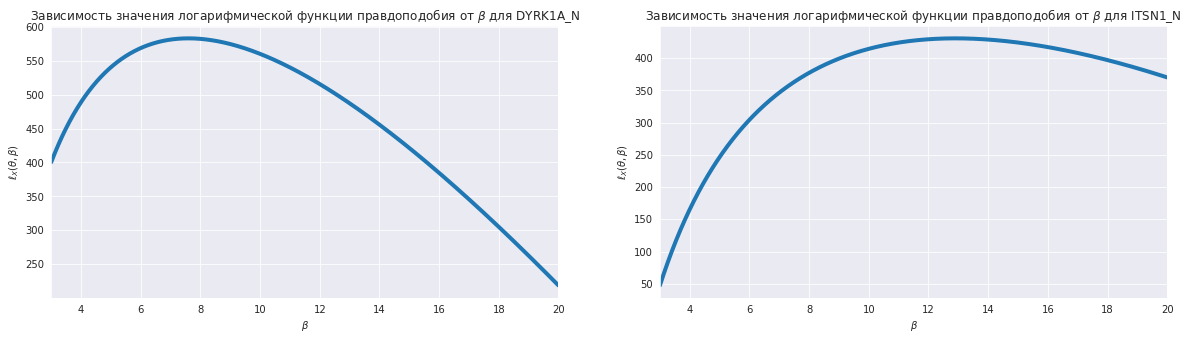

In [85]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for i, col in enumerate(cols):
    axs[i%2].plot(grid, l_vals[col], linewidth=4)
    axs[i%2].set_title(r"Зависимость значения логарифмической функции правдоподобия от $\beta$ для " + col)
    axs[i%2].set_xlim((3, 20))
    axs[i%2].set_xlabel(r"$\beta$")
    axs[i%2].set_ylabel(r'$\ell_X(\theta, \beta)$')

plt.show()

**Вывод:**

По графику лог. функции правдоподобия видно, что мы правильно выбрали пределы сетки, и функция (в данном случае как функция одной переменной) имеет одну точку максимума, которую мы и нашли. Также заметим, что оптимальное $\beta$ отличается от значения, которое мы  предположили в первой части задания.

Постройте для каждого признака на одном графике гистограмму каждого признака, график ядерной оценки плотности и график плотности распределения с параметрами, являющимися полученной ОМП. Графики для разных признаков стройте на разных графиков, но в одном окне. Сравните получившиеся результаты с результатами, полученным в первой части задачи. Сделайте выводы.

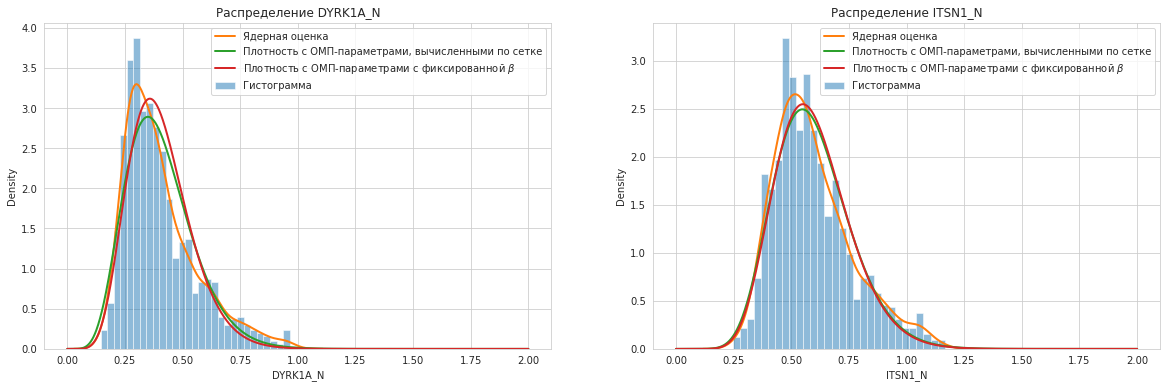

In [86]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

for i, col in enumerate(cols):
    axs[i%2].set_title("Распределение " + col)
    
    sample = clear[col]
    axs[i%2].hist(sample, alpha=0.5, bins=30, density=True, label="Гистограмма")
    sns.kdeplot(sample, ax=axs[i%2], linewidth=2, label="Ядерная оценка")
 
    grid = np.linspace(0, 2, 1000)
    axs[i%2].plot(grid, sps.gamma(scale=1/best_params[col][0], a=best_params[col][1]).pdf(grid), 
                  linewidth=2, label = "Плотность с ОМП-параметрами, вычисленными по сетке")
    axs[i%2].plot(grid, sps.gamma(scale=1/params[col][0], a=params[col][1]).pdf(grid), 
                  linewidth=2, label = r"Плотность с ОМП-параметрами с фиксированной $\beta$")

    axs[i%2].legend()
plt.show()



**Вывод**

Как видим, резльтаты немного отличаются от результатов, полученных в первом пункте. *Различия могут быть разными в зависимости от того, как вы удаляли выбросы.*  Оценки, подобранные по сетке, лучше приближают распределение, но все же, есть небольшой сдвиг относительно ядерной оценки плотности. *Возможно, это можно объяснить тем, что  в датасете имеется несколько разных типов мышей, и на самом деле мы имеем дело со смесью распределений. О том, насколько сильны различия между разными типами мышей, мы, скорее всего, поговорим в следующих дз.*